In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
import nltk

In [22]:
_PATH_A = "12-13-14_Data"
_PATH_B = "6-7_Data"
np.random.seed(42) 
pd.options.display.width = 100
plt.rcParams['figure.dpi'] = 300

# Part A - Times Series Forecasting on Beer Production

In [3]:
_beers = pd.read_csv(f'{_PATH_A}/beer_dataset.csv', error_bad_lines=False)
_beers.head()

,Time,Year,Quarter,Beer.Production
0,1,1956,Q1,284
1,2,1956,Q2,213
2,3,1956,Q3,227
3,4,1956,Q4,308
4,5,1957,Q1,262


In [4]:
col_quarter = _beers["Quarter"]
conditions = [
(col_quarter == "Q1"),
(col_quarter == "Q2"),
(col_quarter == "Q3"),
(col_quarter == "Q4")
]
values = ["01", "04", "07", "10"]
_beers["Month"] = np.select(conditions, values)

_beers["Date"] = pd.to_datetime(_beers[["Year","Month"]].assign(day=1)).dt.to_period("M")
_beers.set_index("Date", inplace=True)

_beers.drop("Quarter", axis=1, inplace=True)
_beers.drop("Time", axis=1, inplace=True)
_beers.drop("Month", axis=1, inplace=True)
_beers.drop("Year", axis=1, inplace=True)

print(_beers.head())


         Beer.Production
Date                    
1956-01              284
1956-04              213
1956-07              227
1956-10              308
1957-01              262


            Beer.Production
Date                       
1956-01-01              284
1956-04-01              213
1956-07-01              227
1956-10-01              308
1957-01-01              262


<AxesSubplot:xlabel='Date'>

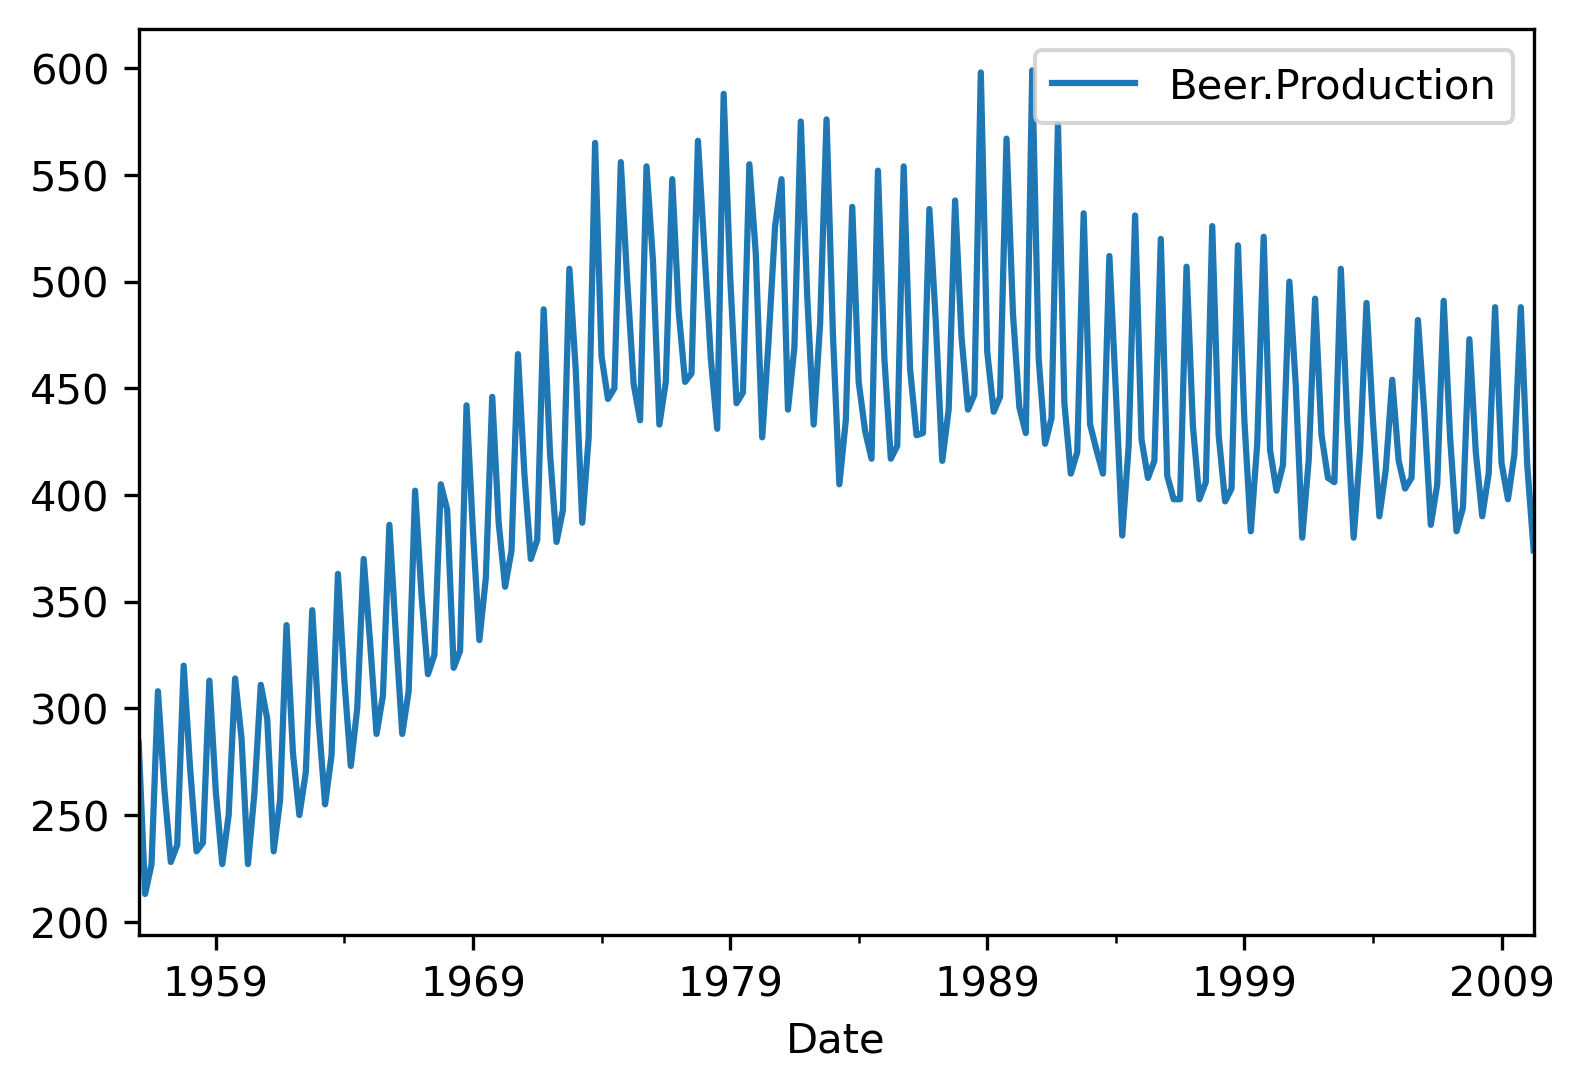

In [5]:
_beers.index = _beers.index.to_timestamp('s').strftime('%Y-%m-%d %H:%M:%S.000')
_beers.index = pd.DatetimeIndex(_beers.index, freq='infer')
print(_beers.head())
_beers.plot()

## Exponential Smoothing

In [6]:
_HORIZON = 12  # The most recent 12 months as the test set
train = _beers.iloc[:-_HORIZON, :]
test = _beers.iloc[-_HORIZON:, :] 
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

RMSE = 12.296374469312562


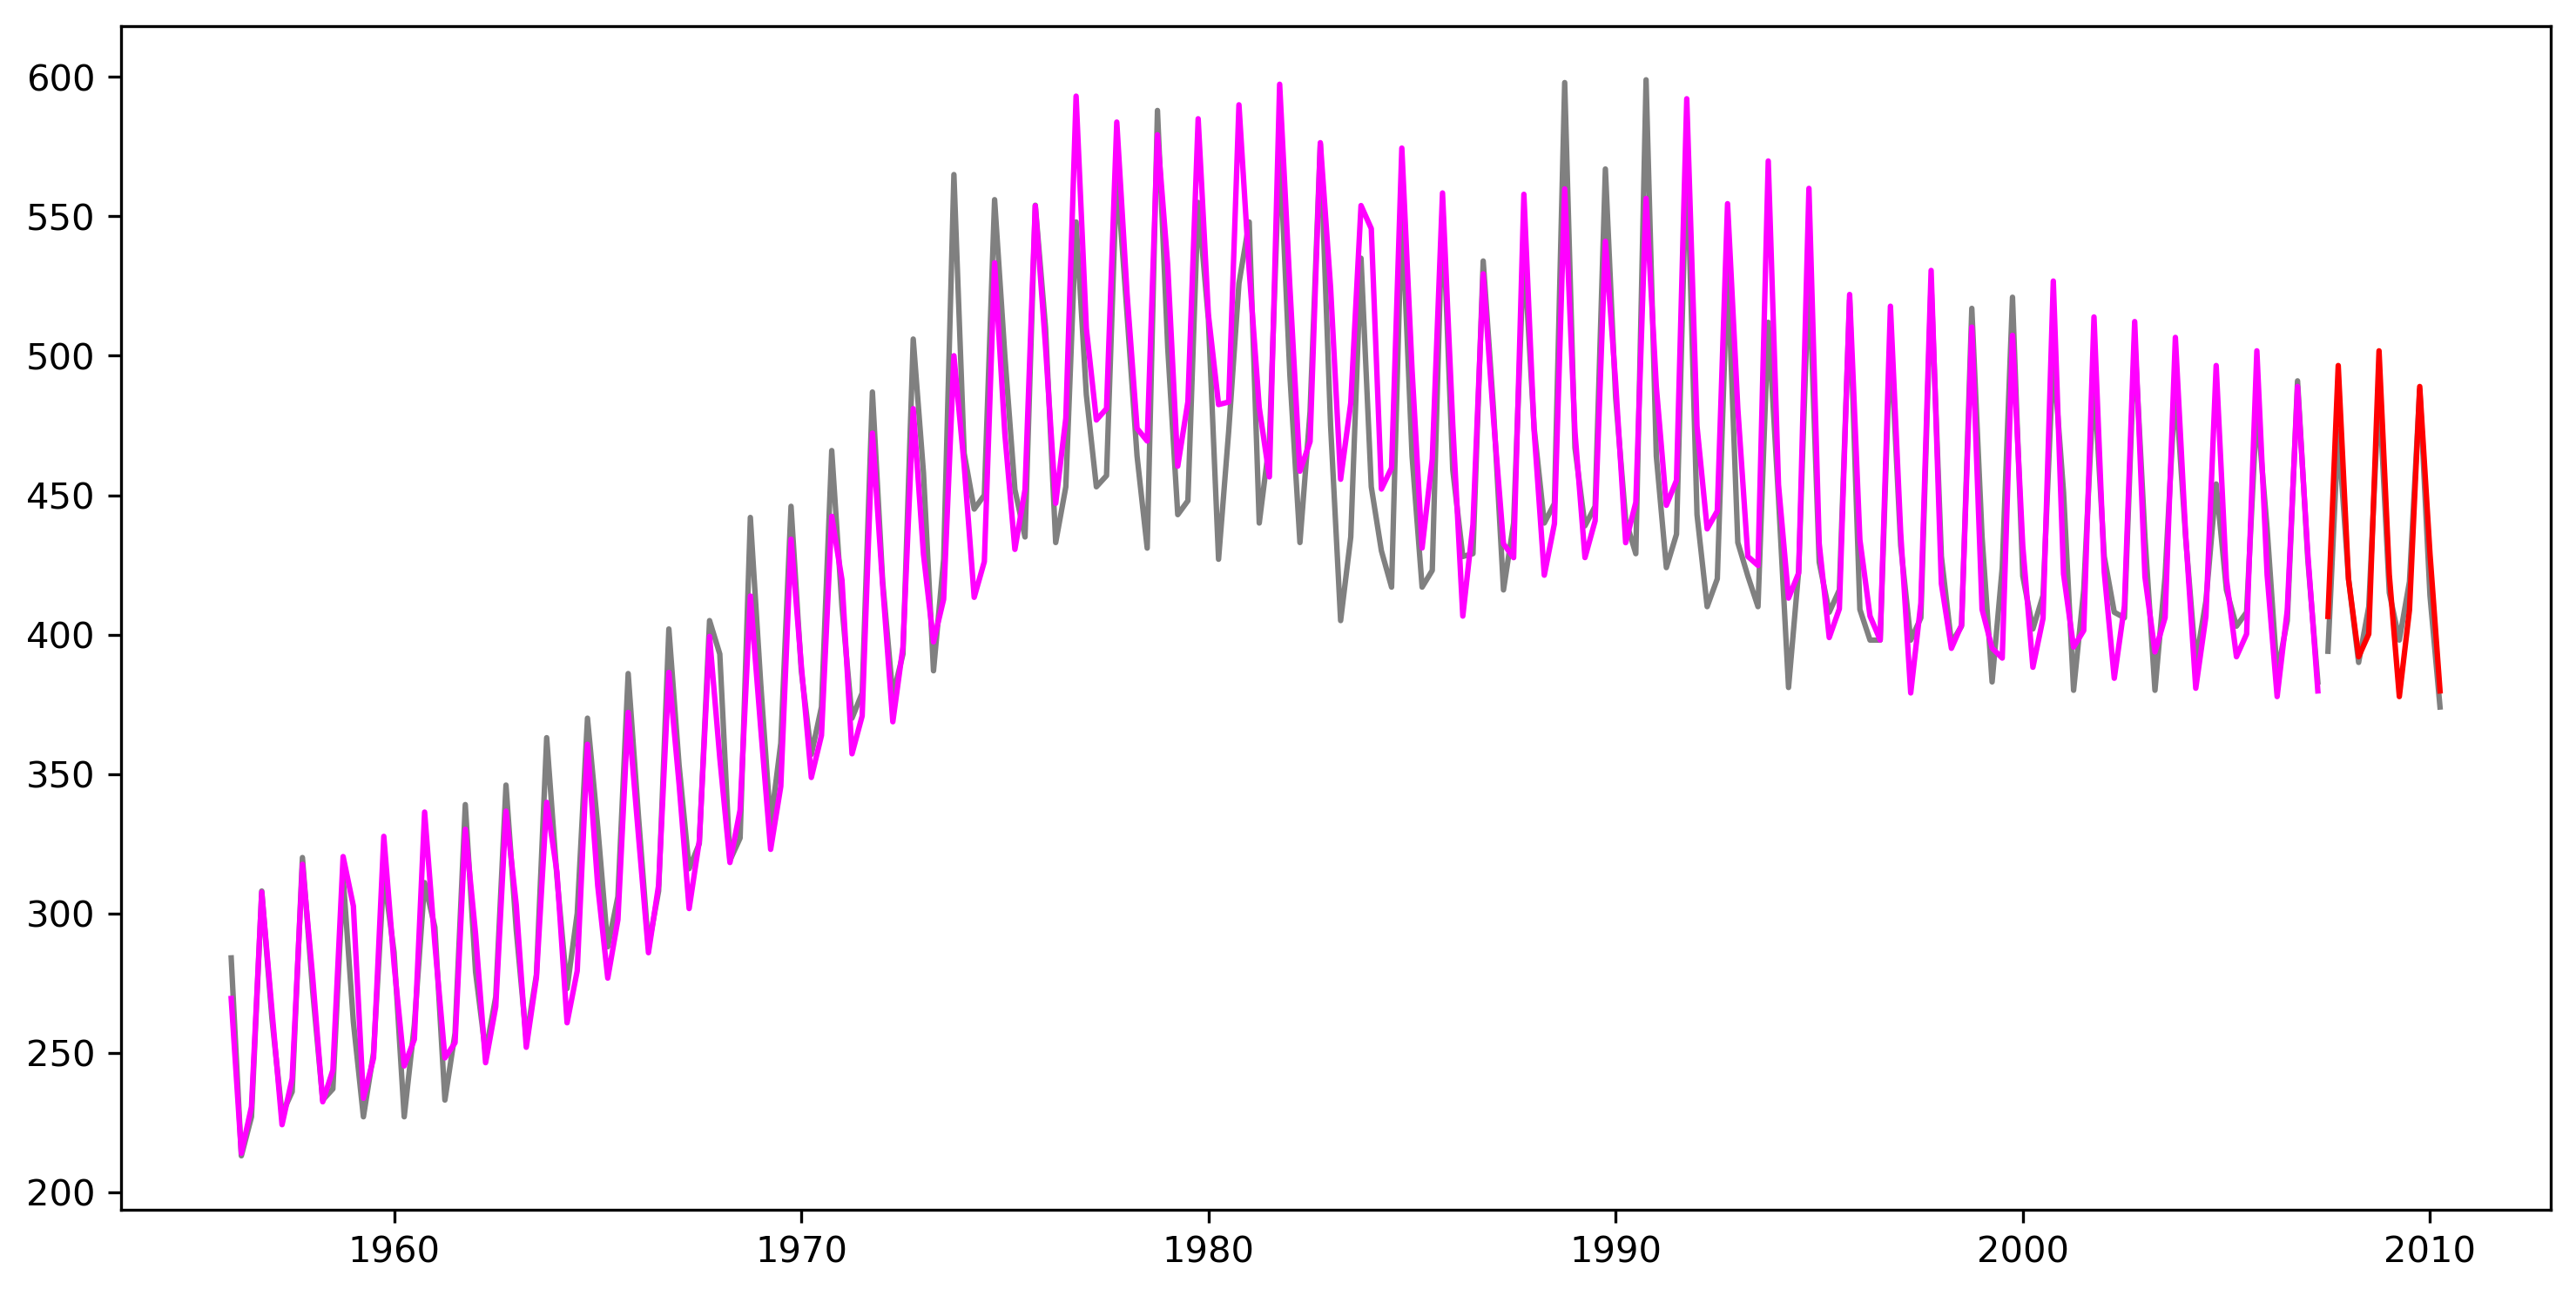

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

model = ExponentialSmoothing(train['Beer.Production'],
                             trend = 'additive', 
                             seasonal = 'additive', 
                             seasonal_periods = _HORIZON
                             )

model_fit = model.fit(smoothing_level=0.07,  # The alpha value of the simple exponential smoothing
                      smoothing_trend=0.05,    # The beta value of the Holt’s trend method
                      smoothing_seasonal=0.6 # The gamma value of the holt winters seasonal method
                      )
model_forecast = model_fit.predict(start=-_HORIZON)

# Plotting the Data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values, color='gray')
ax.plot(test.index, test.values, color="gray")
ax.plot(train.index, model_fit.fittedvalues, color='magenta')
ax.plot(test.index, model_forecast, color='red')

# Model Evaluation
rmse = mean_squared_error(test.values, model_forecast, squared=False)
print(f"RMSE = {rmse}")

## Autoregressive Model

In [8]:
! pip install pmdarima


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1954.055, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2318.206, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2309.776, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2201.345, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2316.216, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2136.469, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2072.249, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1769.586, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1807.056, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1775.284, Time=0.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1772.267, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1893.251, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1803.039, Time=0.23 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1763.310, Time=0.42 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept

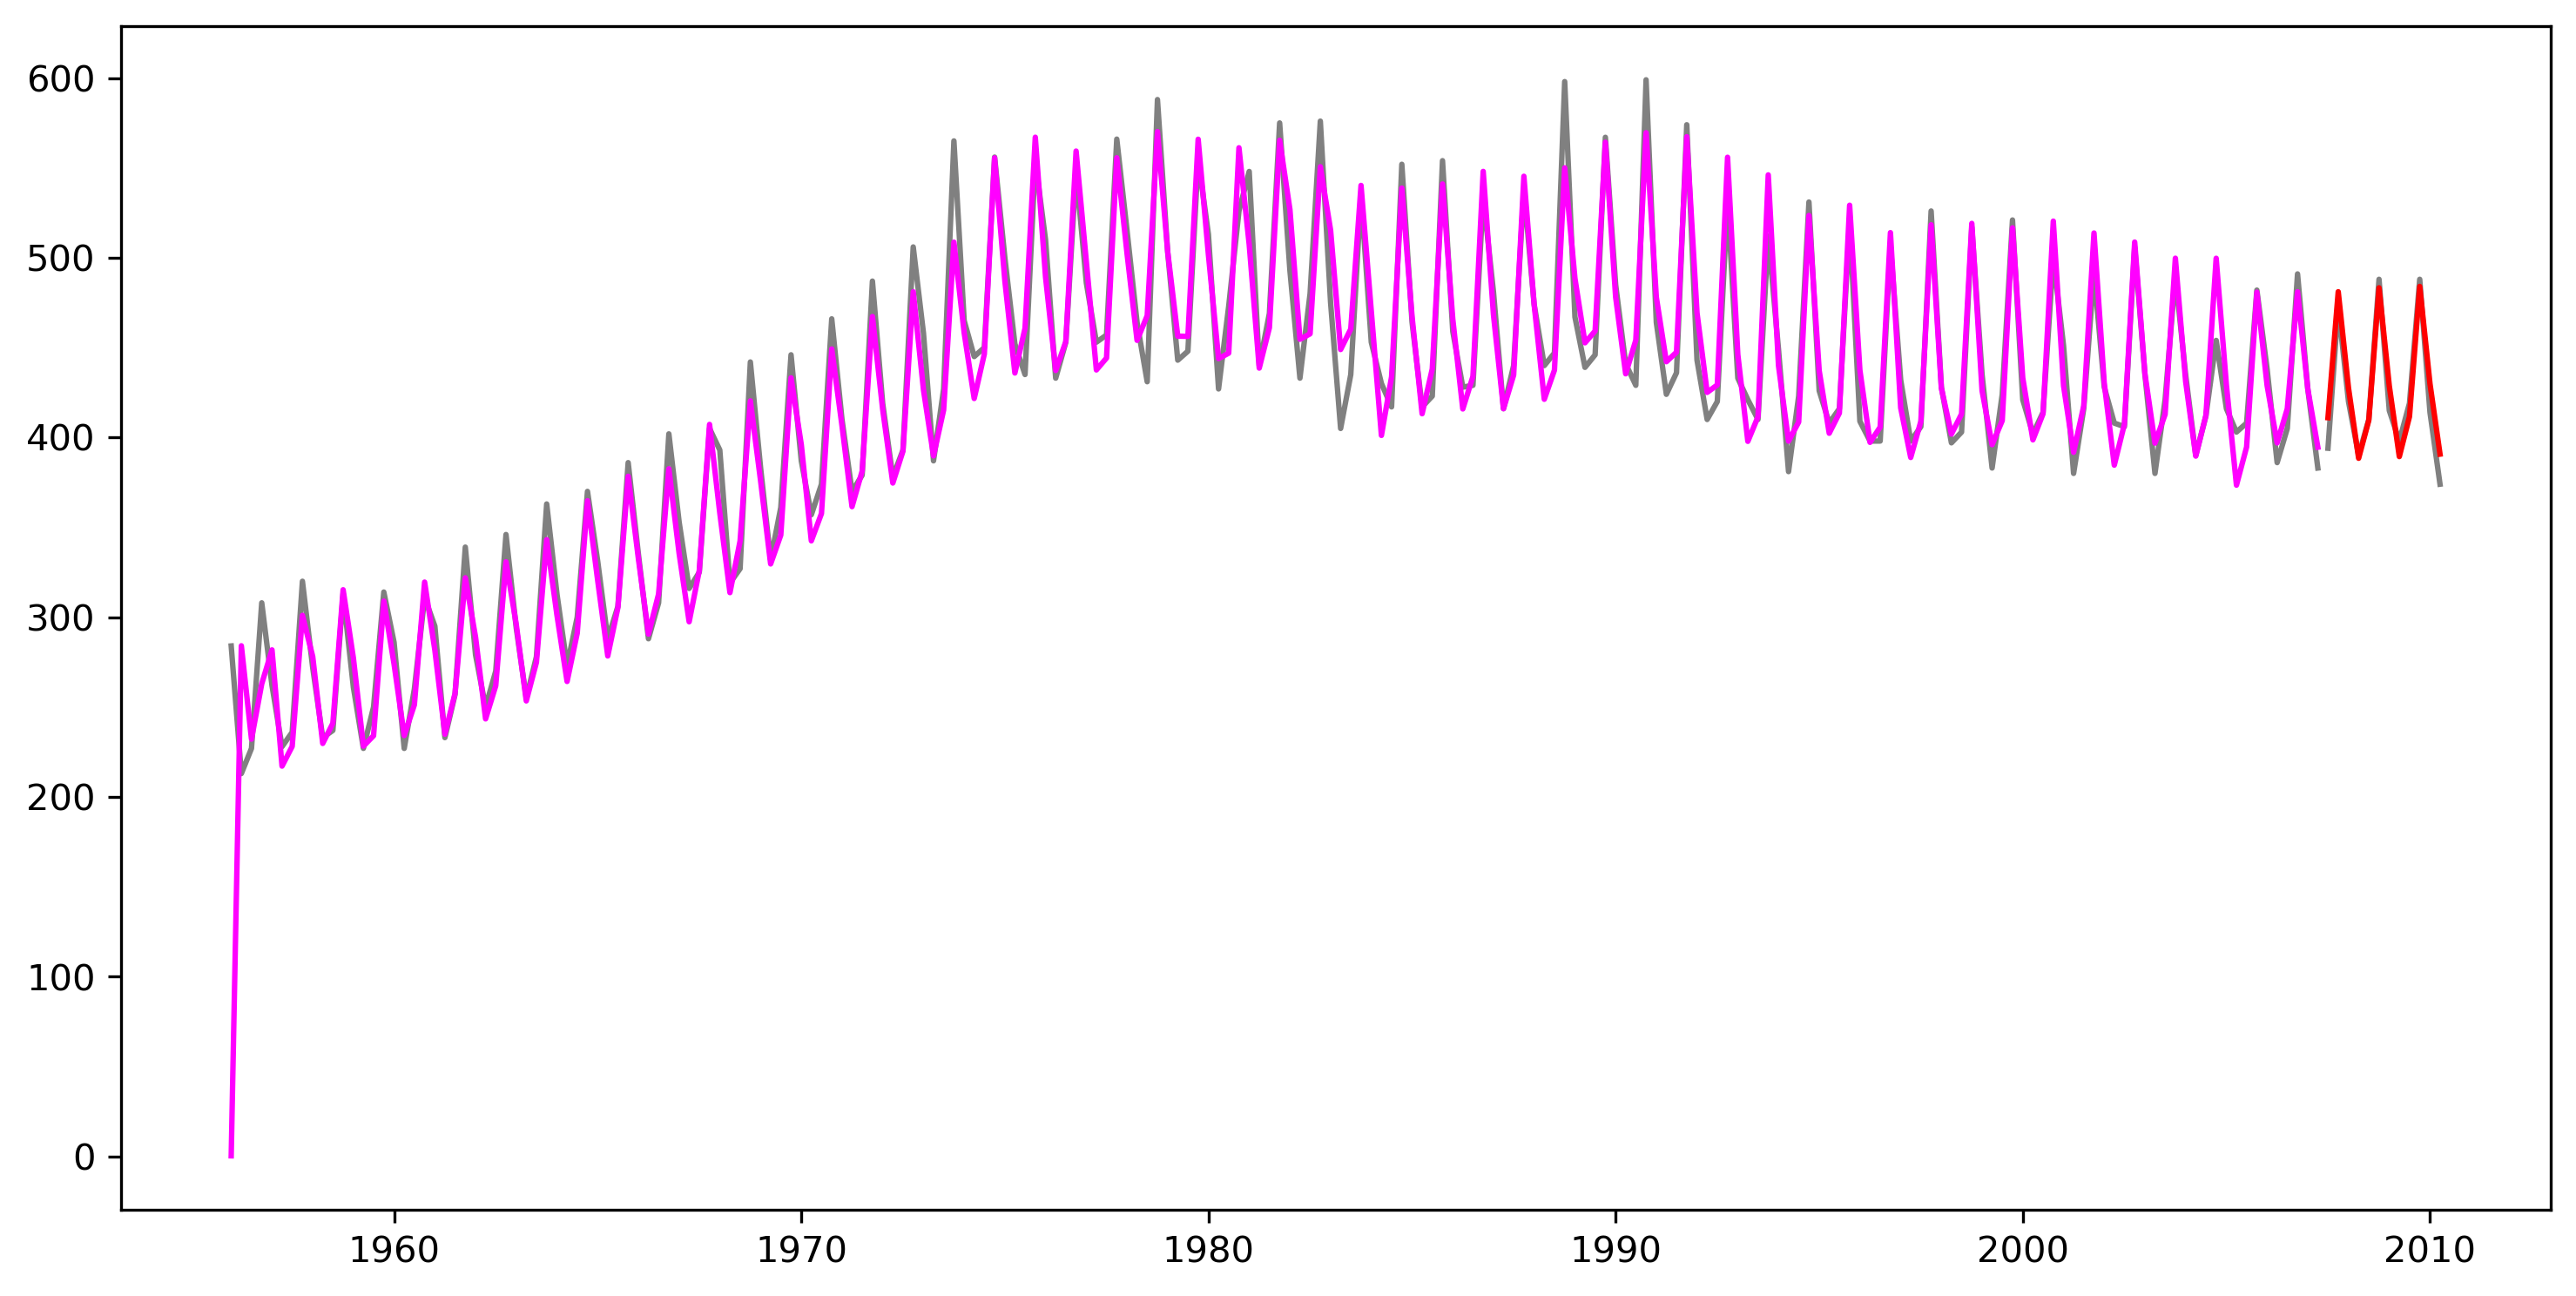

In [56]:
from pmdarima.arima import auto_arima
model = auto_arima(train['Beer.Production'],
                    seasonal=True,
                    trace=True,
                    stepwise=True,
                    random_state=1,
                    n_fits=50) 

model_fit = model.fit(train['Beer.Production'])
model_forecast = model_fit.predict(n_periods = _HORIZON)

# Plotting the Data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values, color='gray')
ax.plot(test.index, test.values, color="gray")
ax.plot(train.index, model_fit.fittedvalues(), color='magenta')
ax.plot(test.index, model_forecast, color='red')

# Model Evaluation
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test.values, model_forecast, squared=False)
print(f"RMSE = {rmse}")

/Users/cameliaguerraoui/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE = 9.90038525929776


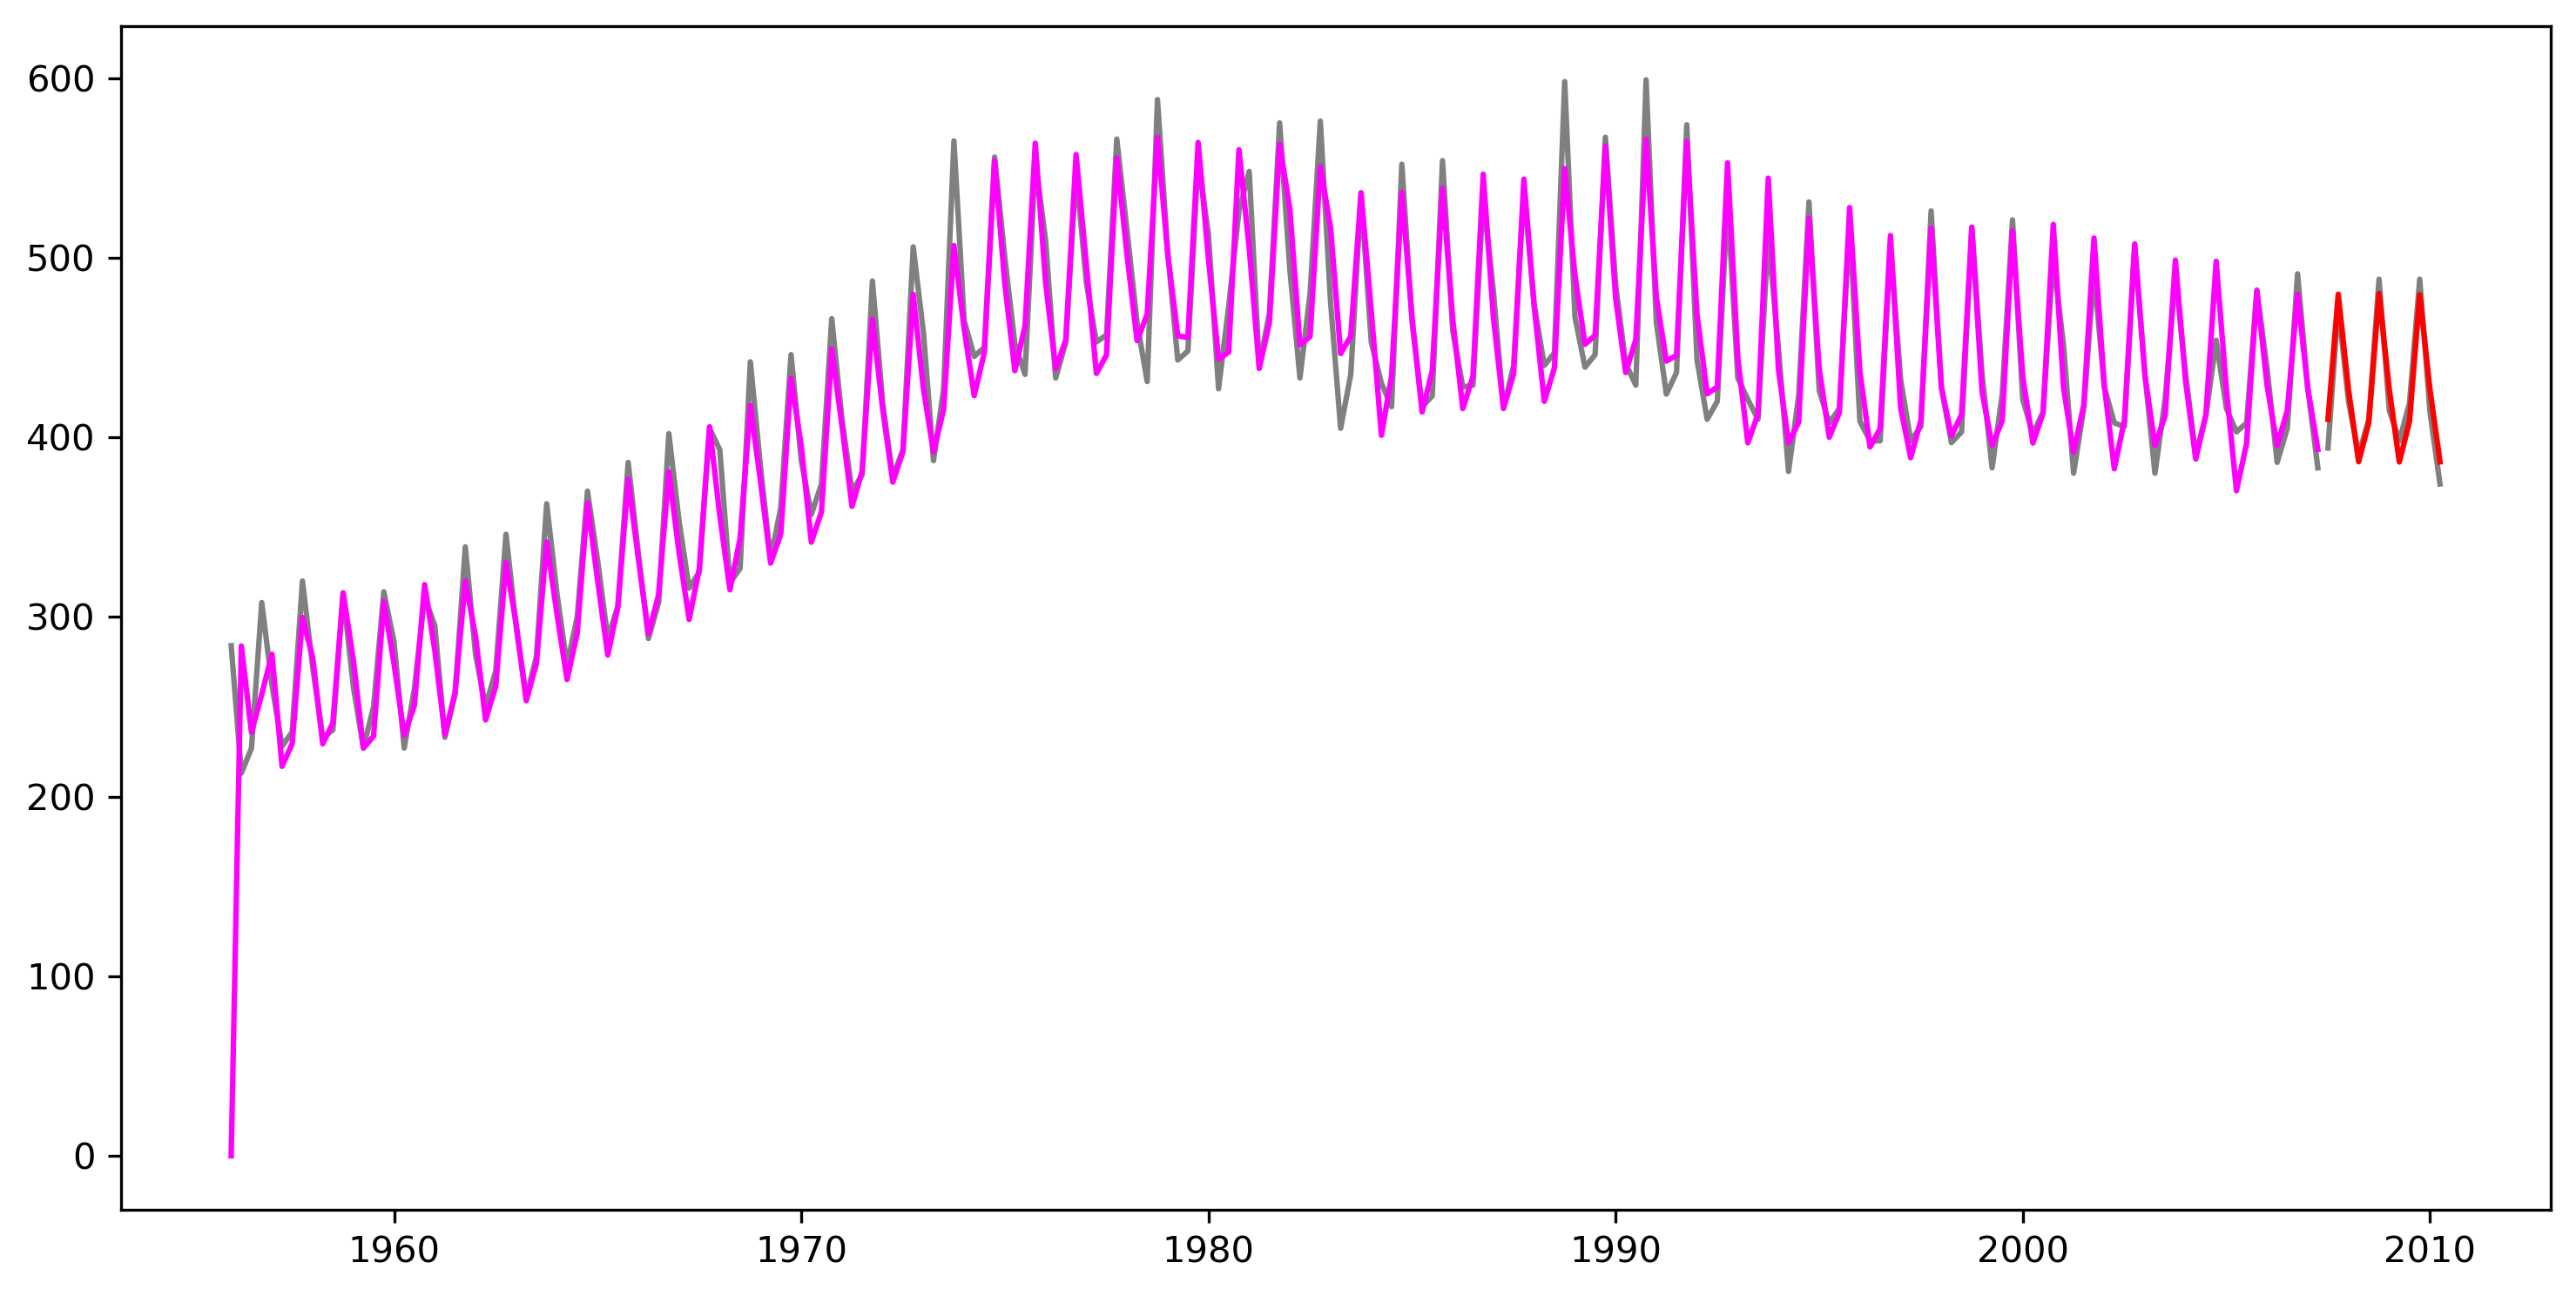

In [37]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Beer.Production'], 
              #seasonal_order=(1,0,0,12) #(P,D,Q,s)
              order=(5,1,3) #(p,d,q)
              ) 

model_fit = model.fit()
model_forecast = model_fit.forecast(_HORIZON)

# Plotting the Data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values, color='gray')
ax.plot(test.index, test.values, color="gray")
ax.plot(train.index, model_fit.fittedvalues, color='magenta')
ax.plot(test.index, model_forecast, color='red')

# Model Evaluation
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test.values, model_forecast, squared=False)
print(f"RMSE = {rmse}")

# Part B - Outlier Detection & Feature Selection

In [24]:
df = pd.read_csv(f"{_PATH_B}/preprocessed_house_sales_data.csv").drop('Unnamed: 0', axis=1)
df_price = pd.read_csv(f"{_PATH_B}/complete.csv")["SalePrice"]
df["Price"] = df_price
df_train = df.values

In [25]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,Price
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,1,0,0,0,0,0,1,0,0,208500.0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,1,0,0,0,0,0,1,0,0,181500.0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,1,0,0,0,0,0,1,0,0,223500.0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,1,0,1,0,0,0,0,0,0,140000.0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,1,0,0,0,0,0,1,0,0,250000.0


## Outliers detection

### KNN based

In [26]:
from scipy.stats import scoreatpercentile
from pyod.models.knn import KNN

outliers_fraction = 0.5

model = KNN(
    contamination=outliers_fraction,
    n_neighbors=3,
    method='mean'
)

model.fit(df_train)

df['anomaly_score'] = model.decision_scores_
df['is_outlier'] = model.predict(df_train)

df_clean = df[df['is_outlier']==0].iloc[:,:-2]

print("Shape Original Dataset: ", df.shape)
print("Shape Clean    Dataset: ", df_clean.shape)

Shape Original Dataset:  (2919, 334)
Shape Clean    Dataset:  (2109, 332)


### Local Outlier Factor (LOF)

In [28]:
from pyod.models.lof import LOF

model = LOF (
    contamination= outliers_fraction,
    n_neighbors=3
)

model.fit(df_train)

df['anomaly_score'] = model.decision_scores_
df['is_outlier'] = model.predict(df_train)

df_clean = df[df['is_outlier']==0].iloc[:,:-2]

print("Shape Original Dataset: ", df.shape)
print("Shape Clean    Dataset: ", df_clean.shape)

Shape Original Dataset:  (2919, 335)
Shape Clean    Dataset:  (2226, 333)


### Cluster-based Local Outlier Factor (CBLOF)

In [17]:
outliers_fraction = 0.3

from pyod.models.cblof import CBLOF

model = CBLOF(
    contamination=outliers_fraction,
    n_clusters = 5,
    alpha = 0.8,
    beta = 2.0
)

model.fit(df_train)

df['anomaly_score'] = model.decision_scores_
df['is_outlier'] = model.predict(df_train)
print(df.head())

df_clean = df[df['is_outlier']==0].iloc[:,:-2]
print(df_clean.head())

SystemError: initialization of _internal failed without raising an exception

: 

### Minimum Covariance Determinant MCD - Model-based

In [29]:
from pyod.models.mcd import MCD

model = MCD (
    contamination= 0.4,
)

model.fit(df_train)

df['anomaly_score'] = model.decision_scores_
df['is_outlier'] = model.predict(df_train)

df_clean = df[df['is_outlier']==0].iloc[:,:-2]

print("Shape Original Dataset: ", df.shape)
print("Shape Clean    Dataset: ", df_clean.shape)


/Users/cameliaguerraoui/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Shape Original Dataset:  (2919, 335)
Shape Clean    Dataset:  (1751, 333)


### Suppression

In [38]:
df.drop(['anomaly_score', 'is_outlier'], inplace=True, axis=1)

In [33]:
df_clean.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,Price
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.293030,...,1,0,0,0,0,0,1,0,0,181500.0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.293030,...,1,0,1,0,0,0,0,0,0,140000.0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.293030,...,1,0,0,0,0,0,1,0,0,250000.0
5,-0.167877,0.672275,0.500430,-0.772420,-0.507197,0.715952,0.513801,-0.569893,0.637774,-0.293030,...,1,0,0,0,0,0,1,0,0,143000.0
7,0.067320,0.000000,0.027119,0.646073,0.391170,0.055700,-0.539116,0.768390,0.916521,-0.103911,...,1,0,0,0,0,0,1,0,0,200000.0


## Feature Selection

In [30]:
df_att = df_clean.copy()
df_att.drop("Price", axis=1, inplace=True)

### PCA

In [31]:
from numpy.linalg import eigh

pca_comp = 5

cov_matrix = np.cov(df_att, rowvar=False)
egnvalues, egnvectors = eigh(cov_matrix)

total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]

egnpairs = [(np.abs(egnvalues[i]), egnvectors[:, i]) for i in range(len(egnvalues))]
egnpairs.sort(key=lambda k: k[0], reverse=True)
projection_matrix = np.hstack([egnpairs[i][1][:, np.newaxis] for i in range(pca_comp)])

df_proj_matrix = pd.DataFrame(projection_matrix.T.round(4), columns=df_att.columns)

features_names = np.absolute(df_proj_matrix).idxmax(axis=1)
print(features_names)

0       YearBuilt
1        2ndFlrSF
2    TotRmsAbvGrd
3       BsmtUnfSF
4    KitchenAbvGr
dtype: object


### Forward/Backward Elimination (Sequential Feature Selection)

In [41]:
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import LinearRegression

model = LinearRegression()
eval_metric = "neg_mean_squared_error"
selector = SequentialFeatureSelector(
    estimator=model,
    direction='forward', # or 'backward'
    scoring=eval_metric,
    n_features_to_select=5,
    #cv=5
)

selector.fit(df_att, df_clean['Price'])
selected_features = selector.transform(df_att)

TypeError: Index(...) must be called with a collection of some kind, 331 was passed

## Predictive Modeling

In [34]:
from sklearn.ensemble import RandomForestRegressor

X = df_att[features_names]
y = df_clean["Price"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,
                                                                            y,
                                                                            test_size=0.1,
                                                                            random_state=1
                                                                        )


k_folds = sklearn.model_selection.KFold(n_splits = 5)

def _evaluate(model, X, y):
    values = sklearn.model_selection.cross_val_score(model,
                                                    X,
                                                    y,
                                                    cv = k_folds,
                                                    scoring="neg_mean_squared_log_error"
                                                )
    print("Eval : ", values.mean())


regressor = RandomForestRegressor(
    n_estimators=90,
)
regressor.fit(X_train, y_train)
prediction = regressor.predict(X_test)
_evaluate(regressor, X_train, y_train)
_evaluate(regressor, X_test, y_test)

Eval :  -0.03635921835406593
Eval :  -0.04345552054670116


In [39]:
X = df.drop("Price", axis=1)
y = df["Price"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,
                                                                            y,
                                                                            test_size=0.1,
                                                                            random_state=1
                                                                        )

regressor.fit(X_train, y_train)
prediction = regressor.predict(X_test)
_evaluate(regressor, X_train, y_train)
_evaluate(regressor, X_test, y_test)

Eval :  -0.04577794089711061
Eval :  -0.0449132784282586
